In [1]:
import numpy as np
import pandas as pd
import random
import copy

from math import sqrt
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import scipy.spatial
from haversine import haversine

import warnings
warnings.filterwarnings('ignore')

#### Download datasets

In [2]:
times = pd.read_csv(rf'./files/times v4.csv', sep=',')
lenght = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='TIDS')
income = pd.read_excel(rf'./files/terminal_data_hackathon v4.xlsx', sheet_name='Incomes')

income = income.set_index('TID')
lenght = lenght.set_index('TID')

random.seed(42)

In [3]:
distance_matrix = times.pivot_table(index = 'Origin_tid', columns = 'Destination_tid', values = 'Total_Time')
distance_matrix = distance_matrix.fillna(0)

# Visualisation

In [4]:
def get_divisors(number):
  result = {1, number}
  for divisor in range(2, number // 2  + 1):
    if number % divisor == 0:
        result.add(divisor)

  result = list(sorted(result))
  lenght_list = len(result)//2

  return result[lenght_list-1:lenght_list+1]

In [5]:
def separation_to_squares(df: pd.DataFrame, n_squares: int=4) -> dict:

    '''
        if n_squares is not power of 2, separetion will be separate for bigger different of metrics
    '''
    if n_squares < 0:
        print('Separation number is negative')
        return {}
    
    north = df.longitude.max()
    south = df.longitude.min()
    east = df.latitude.max()
    west = df.latitude.min()

    result = dict()

    '''
        search divisors for separetion of square
    '''
    if n_squares ** .5 == int(n_squares ** .5):
        multiplies = [int(sqrt(n_squares))-1]*2
    else:
        multiplies = get_divisors(n_squares)
        if multiplies[0] == 1:
            print('Primal number!')
            return result

    '''
        determine the position vaertical or horizontal
    '''
    if (north - south) > (east - west):
        position = 'vertical'
    else:
        position = 'horizontal'


    minimal = multiplies[0]+1
    maximal = multiplies[1]+1
    if multiplies[0] != multiplies[1]:
        if (n_squares != 0) and (n_squares & (n_squares-1) == 0):
                if position == 'vertical':
                    result['longitude'] = list(np.linspace(north, south, minimal))
                    result['latitude'] = list(np.linspace(east, west, maximal))
                else:
                    result['longitude'] = list(np.linspace(east, west, maximal))
                    result['latitude'] = list(np.linspace(north, south, minimal))
        else:
            if position == 'vertical':
                result['longitude'] = list(np.linspace(north, south, minimal))
                result['latitude'] = list(np.linspace(east, west, maximal))
            else:
                result['longitude'] = list(np.linspace(east, west, maximal))
                result['latitude'] = list(np.linspace(north, south, minimal))
    else:
        if position == 'vertical':
            result['longitude'] = list(np.linspace(north, south, minimal+1))
            result['latitude'] = list(np.linspace(east, west, maximal+1))
        else:
            result['longitude'] = list(np.linspace(east, west, maximal+1))
            result['latitude'] = list(np.linspace(north, south, minimal+1))

    result['longitude'] = result['longitude'][1:-1]
    result['latitude'] = result['latitude'][1:-1]
    result['side'] = {'north': north, 'south': south, 'east': east, 'west': west}

    return result


In [6]:
def visualisation_of_squares(df: pd.DataFrame, n_squares: int=4) -> dict:
    if n_squares < 0:
        print('Separation number is negative')
        return dict()
    multiplies = get_divisors(n_squares)
    if multiplies[0] == 1 and not (n_squares ** .5 == int(n_squares ** .5)):
        print('Primal number!')
        return dict()
    
    result = separation_to_squares(df, n_squares)

    fig, axes = plt.subplots(figsize=(12, 12))
    axes.scatter(data=df, x='latitude', y='longitude')

    for x in result['latitude']:
        axes.plot(np.array([x, x]), np.array([result['side']['south'], result['side']['north']]), color='red')

    for x in result['longitude']:
        axes.plot(np.array([result['side']['west'], result['side']['east']]), np.array([x, x]), color='red')
        
    axes.set_xlabel('latitude')
    axes.set_ylabel('longitude')

    return result

In [7]:
#visualisation_of_squares(lenght, 9)

#### Math model

In [8]:
model = copy.deepcopy(income)
RUB = 10**6
days = 14
month_day = 30
downtime = 10

In [9]:
tmp = list(income.columns)
model['mean'] = model[tmp].mean(axis=1)
model['std'] = model[tmp].std(axis=1)
model = model.drop(columns=tmp)

model['day'] = RUB/model['mean']
model['day_with_limit'] = np.where(model.day>=14, 14, model.day)
model['number_trips'] = month_day/model.day_with_limit
model['limit'] = model['day_with_limit'].round(0)
model['quantity'] = 1

In [10]:
pivotmodel2 = model.groupby(by='limit')[['quantity']].sum().reset_index()
pivotmodel2['loop'] = pivotmodel2.quantity / pivotmodel2.limit.max()
pivotmodel2['case_loop'] = pivotmodel2.limit.max() / pivotmodel2.limit
pivotmodel2['category'] = np.where(pivotmodel2.case_loop < 2, 'b', 'a')

In [11]:
model = model.reset_index().merge(pivotmodel2[['limit', 'category']], on='limit', how='left')
model = model.set_index('TID')

#### K-Means Classtering

In [12]:
A_category = lenght.merge(model.query('category == "a"')[['number_trips']], left_index=True, right_index=True, how='inner')
B_category = lenght.merge(model.query('category == "b"')[['number_trips']], left_index=True, right_index=True, how='inner')
df = lenght.merge(model[['number_trips']], left_index=True, right_index=True, how='inner')

In [13]:
class Clastering():

    def __init__(self, df: pd.DataFrame, case: str, claster_limit: float, figsize: tuple=(5,3)):
        self.df = df
        self.case = case
        self.claster_limit = claster_limit
        self.__k = claster_limit+1
        self.figsize = figsize


    def distance(self, p1, p2):
        return haversine(p1[1:],p2[1:])
    

    def cluster_centroids(self, vals, clusters, k):
        results=[]
        for i in range(k):
            results.append(np.average(vals[clusters == i],weights=np.squeeze(np.asarray(vals[clusters == i][:,[0]])),axis=0))
        return results


    def kmeans(self, vals, k=None, centroids=None, steps=20):
        centroids = vals[np.random.choice(np.arange(len(vals)), k, False)]
        elbow = []
        for _ in range(max(steps, 1)):
            sqdists = scipy.spatial.distance.cdist(centroids, vals, lambda u, v: (self.distance(u,v)**2))
            elbow.append(sqdists)
            clusters = np.argmin(sqdists, axis=0)
            new_centroids = self.cluster_centroids(vals, clusters, k)
            if np.array_equal(new_centroids, centroids):
                break
            centroids = new_centroids
        
        return clusters, centroids, elbow


    def SSE(self) -> dict:
        vals = self.df[[self.case,'latitude','longitude']].values
        sse=[]
        data = {}
        try:
            for k in range(1,self.__k):
                clusters, centroids, elbow=self.kmeans(vals, k)
                sqdist = np.sum((elbow-np.mean(elbow))**2)
                sse.append(sqdist)
                data[k] = {'clusters': clusters, 'centroids': centroids, 'elbow': elbow}

            sse=sorted(sse,reverse=True)
            return {'sse': sse, 'data': data}
        except Exception:
            return self.SSE()

    def define_claster_limit(self, sse: list) -> list[int]:
        return [self.claster_limit, sse[self.claster_limit-1]]
        # for x in sse:
        #     if x <= self.claster_limit:
        #         c.append(sse.index(x)+1)
        #         c.append(x)
        #         return c

    
    def visualisation_claster(self) -> dict:
        df = self.SSE()
        sse = df['sse']
        fig = plt.figure(figsize=(5,3))
        c = self.define_claster_limit(sse)
        x=list(range(1,self.__k))
        labels=x
        plt.plot(x,sse,'r')
        plt.scatter(x,sse,marker='x')
        plt.xticks(x, labels)
        plt.title('Elbow Method')
        plt.xlabel('K')
        plt.ylabel('SSE Distance')
        plt.plot([c[0], c[0]], [0, c[1]], color='green', linestyle='dashed', linewidth=2)  # plotting the arbitrary line from point (25,10) to (65,45).    
        plt.show()
        df['clester_count'] = c[0]
        return df


    def selections(self):
        scce = self.visualisation_claster()
        data = scce['data'][scce['clester_count']]

        self.df['c']=[int(c) for c in data['clusters']]

        lats = [data['centroids'][i][1] for i in range(scce['clester_count'])]
        self.df['clat'] = self.df['c'].map(lambda x: lats[x])

        longs = [data['centroids'][i][2] for i in range(scce['clester_count'])]
        self.df['clong'] = self.df['c'].map(lambda x: longs[x])

        return self.df, scce
    

    @staticmethod
    def plot_clasters(df, k):
        c_lat=list(set(df['clat']))
        c_long=list(set(df['clong']))

        fig, ax = plt.subplots(figsize=(10, 6))
        colors = ['gold', 'cornflowerblue', 'limegreen', 'violet', 'pink', 
                  'brown', 'salmon', 'aqua', 'olive', 'chocolate',
                  'indigo', 'orchid', 'silver', 'peru', 'navu']
        for x in range(k):
            x1=df.query(f'c=={x}')['latitude'].values.tolist()
            y1=df.query(f'c=={x}')['longitude'].values.tolist()
            plt.scatter(y1,x1, color=colors[x])
        plt.scatter(c_long,c_lat,marker='x', color='black')
        plt.show()
        

In [14]:
A_category = Clastering(A_category, 'number_trips', 14)
B_category = Clastering(B_category, 'number_trips', 14)
df = Clastering(df, 'number_trips', 14)

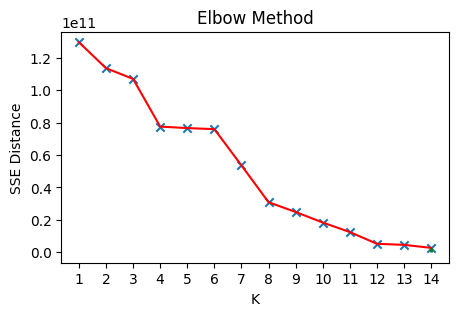

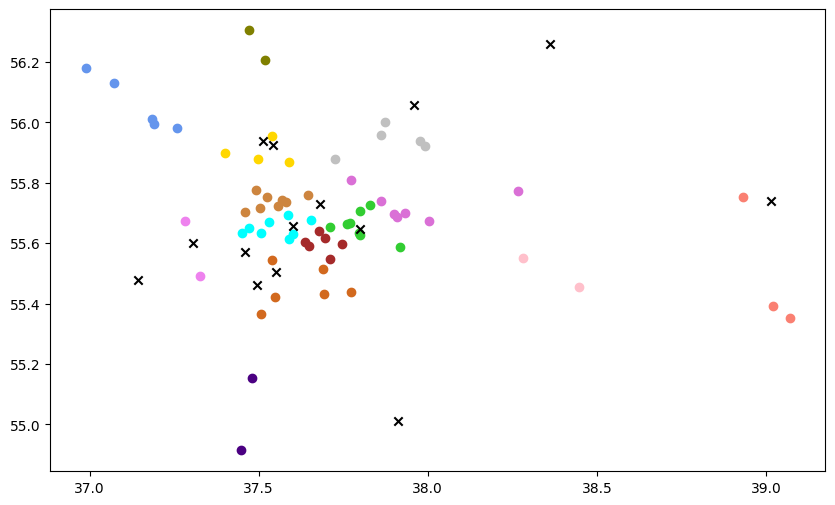

In [15]:
A_category, scce = A_category.selections()
Clastering.plot_clasters(A_category, scce['clester_count'])

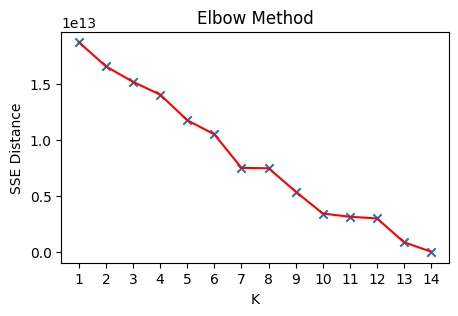

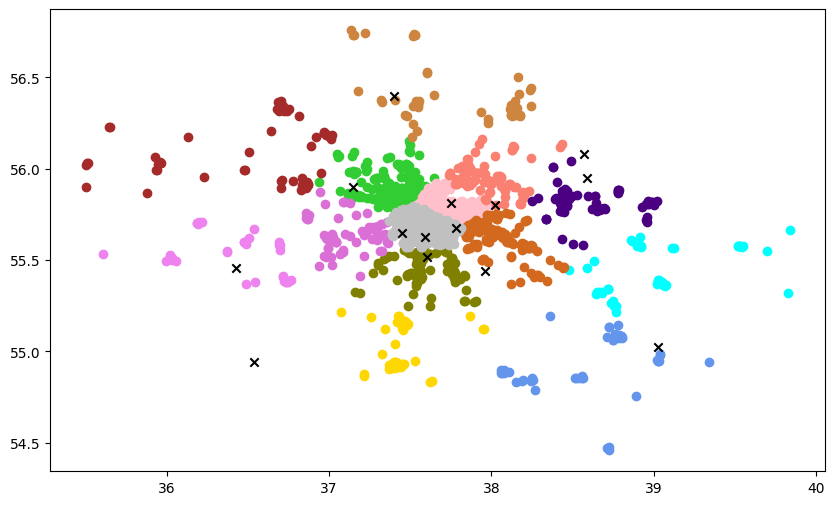

In [16]:
B_category, scce = B_category.selections()
Clastering.plot_clasters(B_category, scce['clester_count'])

#### K-Means Classtering (added)

In [20]:
A_category = A_category.reset_index()
B_category = B_category.reset_index()
model_added = copy.deepcopy(model)


def float_to_int(base: int, x: float) -> int:
    x = str(x).split('.')
    return int(x[0])*base + int(x[1])

In [21]:
A_claster = times.merge(A_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
A_claster = A_claster.merge(A_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

B_claster = times.merge(B_category[['TID', 'c']], left_on='Origin_tid', right_on='TID', how='left')
B_claster = B_claster.merge(B_category[['TID', 'c']], left_on='Destination_tid', right_on='TID', how='left')

In [44]:
A_claster = A_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})
B_claster = B_claster.query('c_x==c_y').drop(columns=['TID_x', 'TID_y', 'c_y']).rename(columns={'c_x': 'cluster'})


In [46]:

l = pd.DataFrame({
      'Mean Time': A_claster.query(f'cluster=={x}').Total_Time.mean(), 
      'Number of points': A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
      'Time %': (A_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * A_claster.query(f'cluster=={x}').Total_Time.mean(),
      'Number of cluster': x} for x in range(scce['clester_count']))
print(l)
print()
print(l['Mean Time'].mean())

    Mean Time  Number of points    Time %  Number of cluster
0   15.056667                 4  0.036949                  0
1   19.358500                 5  0.059382                  1
2   14.554286                 8  0.071432                  2
3   38.510000                 2  0.047252                  3
4   23.815000                 2  0.029221                  4
5   11.496000                 6  0.042317                  5
6   43.455000                 3  0.079979                  6
7   13.873571                 8  0.068091                  7
8   15.160000                 2  0.018601                  8
9   23.488333                 6  0.086460                  9
10  30.915000                 2  0.037933                 10
11  28.330000                 7  0.121663                 11
12  20.755000                 5  0.063666                 12
13  10.754643                 8  0.052784                 13

22.108714285714285


In [47]:
l = pd.DataFrame({
      'Mean Time': B_claster.query(f'cluster=={x}').Total_Time.mean(), 
      'Number of points': B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0],
      'Time %': (B_claster.query(f'cluster=={x}').drop_duplicates(subset='Origin_tid', keep='first').shape[0]/model.shape[0]) * B_claster.query(f'cluster=={x}').Total_Time.mean(),
      'Number of cluster': x} for x in range(scce['clester_count']))
print(l)
print()
print(l['Mean Time'].mean())

    Mean Time  Number of points    Time %  Number of cluster
0   30.081166                47  0.867371                  0
1   53.777218                59  1.946537                  1
2   26.046771               200  3.195923                  2
3   45.096188                38  1.051322                  3
4   18.798624               247  2.848626                  4
5   53.479672                61  2.001387                  5
6   29.919295               115  2.110871                  6
7   45.972232                46  1.297376                  7
8   26.575298               114  1.858640                  8
9   31.535883               166  3.211630                  9
10  32.173741                92  1.815941                 10
11  26.557086                74  1.205659                 11
12  18.941296               242  2.812143                 12
13  45.664426                61  1.708914                 13

34.6156354587645


In [49]:
A_model = model_added.merge(A_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')
B_model = model_added.merge(B_claster.drop_duplicates(subset='Origin_tid', keep='first').set_index('Origin_tid')[['Total_Time', 'cluster']], left_index=True, right_index=True, how='inner')

In [50]:
A_model['downtime'] = downtime * 60
A_model['Total_Time'] = A_model['Total_Time'].apply(lambda x: float_to_int(100, x))
A_model['Common_Time'] = A_model[['Total_Time', 'downtime']].sum(axis=1)
A_model['Car_per_minute'] = 20000/(12*60)
A_model['Maintenance_cost_one_time'] = A_model['Common_Time']/60 * A_model['Car_per_minute']
A_model['Maintenance_cost_per_month'] = A_model['number_trips'] * A_model['Maintenance_cost_one_time']
A_model['Car_time'] = A_model['number_trips'] * A_model['Common_Time']/60
((A_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

461416.66530797107

In [51]:
B_model['downtime'] = downtime * 60
B_model['Total_Time'] = B_model['Total_Time'].apply(lambda x: float_to_int(100, x))
B_model['Common_Time'] = B_model[['Total_Time', 'downtime']].sum(axis=1)
B_model['Car_per_minute'] = 20000/(12*60)
B_model['Maintenance_cost_one_time'] = B_model['Common_Time']/60 * B_model['Car_per_minute']
B_model['Maintenance_cost_per_month'] = B_model['number_trips'] * B_model['Maintenance_cost_one_time']
B_model['Car_time'] = B_model['number_trips'] * B_model['Common_Time']/60
((B_model.Car_time.sum() / month_day) / (12*60)) * 20000 * 30

4044304.9396350933

### Reesrt of routes

In [55]:
income.columns = pd.to_datetime(income.columns).date
start = income.columns[0]

In [56]:
residue = income[[start]].reset_index()
residue['Date'] = start
residue['Number_day'] = 0
residue = residue.rename(columns={'TID': 'Id', start: 'Balance_close'})
reestr = pd.DataFrame([], columns=['Id', 'Balance_open', 'Income', 'Outcome', 'Balance_close', 'Date', 'Number_day'])
reestr = pd.concat([reestr, residue]).fillna(0)

In [58]:
if False:
    for x in list(income.columns)[1:]:

        nextday = income[[x]]
        nextday = nextday.reset_index()
        nextday['Date'] = x
        nextday = nextday.rename(columns={'TID': 'Id', x: 'Income'})

        for y in list(nextday.Id):
            reestr_tmp = reestr.query(f'Id=={y}').tail(1)
            nextday_tmp = nextday.query(f'Id=={y}')

            nextday_tmp['Balance_open'] = reestr_tmp.Balance_close.values[0]

            nextday_tmp['Number_day'] = reestr_tmp.Number_day.values[0]+1
            nextday_tmp['Outcome'] = np.where((nextday_tmp.Number_day >= 14) | (nextday_tmp.Balance_open >= 10**6), nextday_tmp.Balance_open, 0)

            nextday_tmp['Number_day'] = np.where((nextday_tmp.Number_day.values[0] >= 14) | (nextday_tmp.Outcome !=0), 1, nextday_tmp.Number_day)
            nextday_tmp['Balance_close'] = nextday_tmp.Balance_open + nextday_tmp.Income - nextday_tmp.Outcome

            reestr = pd.concat([reestr, nextday_tmp]).fillna(0)
    reestr.to_csv(rf'./files/reestr2.csv', index=False)

In [ ]:
pivot = pd.read_csv(rf'./files/reestr2.csv')
pivot['signal'] = np.where(pivot.Outcome != 0, 1, np.nan)
pivot = pivot.pivot_table(index='Date', values='signal', aggfunc='sum')
pivot.to_excel(rf'./files/pivot.xlsx')